In [1]:
%load_ext autoreload

%autoreload 2

import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle
from os.path import join

import joblib
from concurrent.futures import ProcessPoolExecutor
import re

from backports import tempfile

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma

import psrchive

import pipe

plt.viridis()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [2]:
observations = ['56736.85_AO_1400',
                '56584.26_AO_430',
                '56781.71_AO_3000',
                '56781.75_AO_2000']

In [10]:
for o in observations:
    od = join("data/obs-pass1",o)
    files = sorted(glob(join(od,"clean_*.ar")))
    print files
    subprocess.check_call(["psradd", 
                           "-T", 
                           "-o", join(od,"clean.tscr")]
                          + files)
                           

['data/obs-pass1/56736.85_AO_1400/clean_0000.ar', 'data/obs-pass1/56736.85_AO_1400/clean_0001.ar', 'data/obs-pass1/56736.85_AO_1400/clean_0002.ar']
['data/obs-pass1/56584.26_AO_430/clean_0000.ar']
['data/obs-pass1/56781.71_AO_3000/clean_0000.ar', 'data/obs-pass1/56781.71_AO_3000/clean_0001.ar', 'data/obs-pass1/56781.71_AO_3000/clean_0002.ar', 'data/obs-pass1/56781.71_AO_3000/clean_0003.ar']
['data/obs-pass1/56781.75_AO_2000/clean_0000.ar', 'data/obs-pass1/56781.75_AO_2000/clean_0001.ar', 'data/obs-pass1/56781.75_AO_2000/clean_0002.ar', 'data/obs-pass1/56781.75_AO_2000/clean_0003.ar', 'data/obs-pass1/56781.75_AO_2000/clean_0004.ar', 'data/obs-pass1/56781.75_AO_2000/clean_0005.ar', 'data/obs-pass1/56781.75_AO_2000/clean_0006.ar']


In [11]:
for o in observations:
    f = join("data/obs-pass1",o,"clean.tscr")
    if not os.path.exists(f):
        print "Missing tscrunch file in", o
        continue
    op = subprocess.check_output(["rmfit", "-m", "-60,60,240", "-r", f])
    print o
    print op

56736.85_AO_1400
Best RM is: 30.4521 +/- 0.86

56584.26_AO_430
Best RM is: -34.5372 +/- 2.74

56781.71_AO_3000
Best RM is: -44.9372

56781.75_AO_2000
Best RM is: 70.5216 +/- 26.33



In [12]:
rms = {'56736.85_AO_1400':30,
       '56584.26_AO_430':-30,
       '56781.71_AO_3000':30,
       '56781.75_AO_2000':30}

In [16]:
for o in observations:
    f = join("data/obs-pass1",o,"clean.tscr")
    subprocess.check_call(["pam", 
                           "-R", str(rms[o]),
                           "-e", "profile",
                           "-b", "4",
                           "-F",
                           f])
    subprocess.check_call(["pav",
                           "-S",
                           "-g", o+".bS.eps/cps",
                           join("data/obs-pass1",o,"clean.profile")])


56736.85_AO_1400 21.313 0.0463786560699
56584.26_AO_430 21.313 0.479966085287
56781.71_AO_3000 21.313 0.0103887118049
56781.75_AO_2000 21.313 0.0191744379668


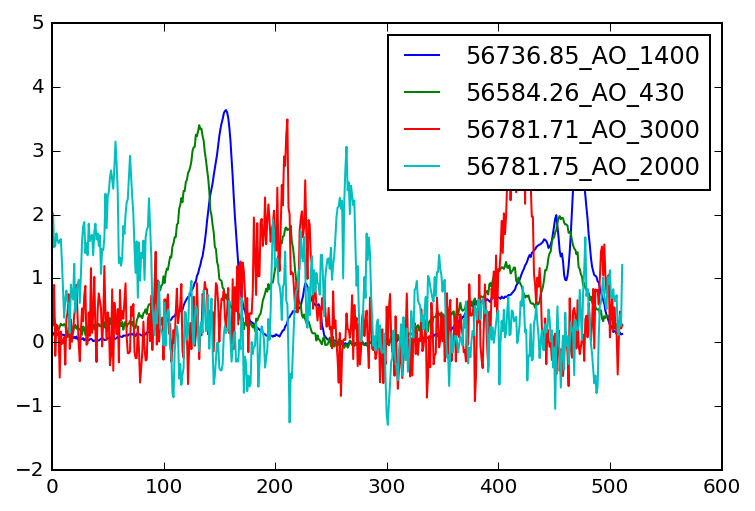

In [64]:
for o in observations:
    #plt.figure()
    f = join("data/obs-pass1",o,"clean.profile")
    F = psrchive.Archive_load(f)
    F.remove_baseline()
    F.convert_state("Stokes")
    dm = F.get_dispersion_measure()
    P = F.get_Integration(0).get_folding_period()
    iquv = F.get_data()[0,:,0,:]
    #plt.plot(iquv[0,:])
    dm_delay = 4.148808e3*F.get_centre_frequency()**(-2)*dm
    F.rotate(dm_delay) # positive is earlier
    #F.rotate_phase(dm_delay/P) # positive is earlier
    iquv = F.get_data()[0,:,0,:]
    iquv /= np.sqrt(np.mean(iquv[0,:]**2))
    plt.plot(iquv[0,:],label=o)
    plt.legend(loc="best")
    np.savetxt(o+".iquv.txt", iquv)
    print o, dm, dm_delay

In [40]:
np.savetxt?

In [44]:
F.get_centre_frequency()

2147.4479166666665

In [57]:
F.dededisperse()